**QUESTION:** Should we buy or sell in 3 days?

The idea behind this mini project:

* Create data features from the price of the day
* Check the performance with different models
 * ARIMA
 * Random Forest
 * LSTM
* Obtain a __model that can predict in some manner how the price is going to move in the following three days__.

## Import Libraries

In [1]:
!pip install pmdarima

In [2]:
import os
import io
import math
import random
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
import matplotlib.dates as mdates
import datetime as dt
from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-colorblind')

import warnings
warnings.filterwarnings("ignore")

## Getting the Data

In [3]:
def download_file(url, filename):
    r = requests.get(url, stream=True)

    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    total_kb_size = math.ceil(total_size//block_size)
    
    wrote = 0 
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=total_kb_size , unit='KB', unit_scale=True):
            wrote = wrote  + len(data)
            f.write(data)

In [4]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    download_file("https://www.coingecko.com/price_charts/export/279/eur.csv", datafile)

data = pd.read_csv(datafile)

In [5]:
# Only we take care of the last year to date
data = data[-365:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 1563 to 1927
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   snapped_at    365 non-null    object 
 1   price         365 non-null    float64
 2   market_cap    365 non-null    float64
 3   total_volume  365 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [6]:
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

## Analysis

Decomposing Time Series into several components- Trend, Seasonality and Random noise

The **additive model** is Y[t] = T[t] + S[t] + e[t]

The **multiplicative model** is Y[t] = T[t] * S[t] * e[t]


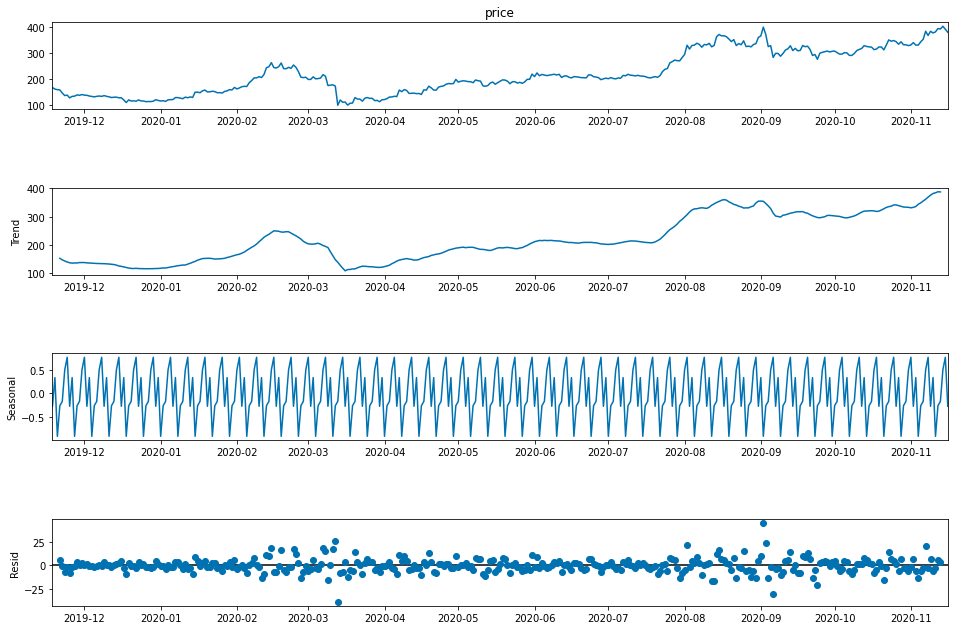

In [7]:
import statsmodels.api as sm
seas_d = sm.tsa.seasonal_decompose(data.price, model='additive')

fig = seas_d.plot()
fig.set_figheight(10)
fig.set_figwidth(15)

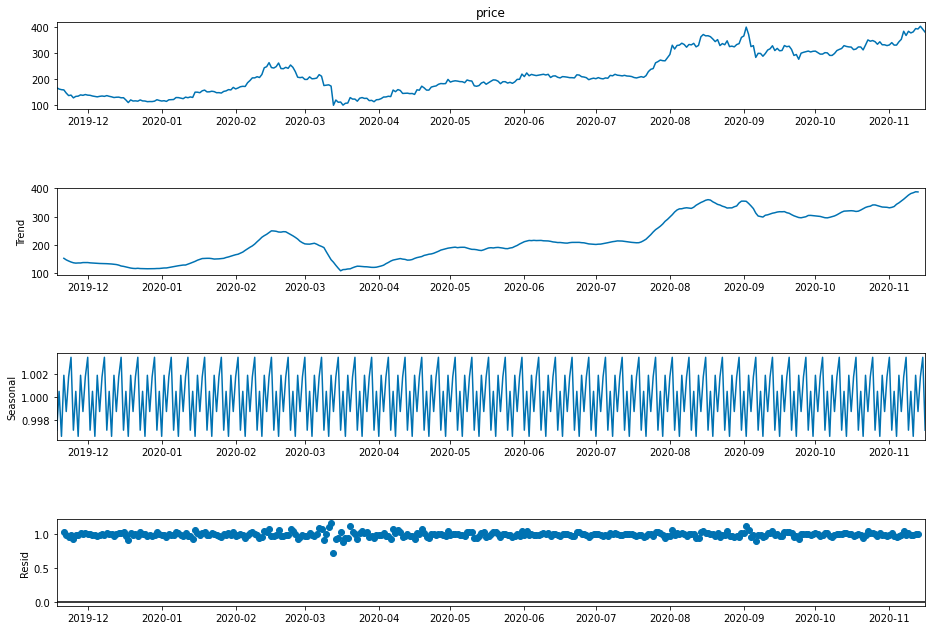

In [8]:
seas_d = sm.tsa.seasonal_decompose(data.price, model='multiplicative')

fig = seas_d.plot()
fig.set_figheight(10)
fig.set_figwidth(15)

**Insights:**
* Multiplicative fits better
* There seems to be a week seasonality

In [9]:
# Multiplicative fits better, so changing to log to convert mult by sum
data['log_price'] = np.log(data.price)

## Data Engineering

In [10]:
data['future'] = data.price.shift(-3)
data['log_future'] = data.log_price.shift(-3)
data = data[:-3]
data.tail()

,price,market_cap,total_volume,log_price,future,log_future
snapped_at,,,,,,
2020-11-09,382.879431,4.345975e+10,9.379498e+09,5.947720,393.226201,5.974385
2020-11-10,376.434620,4.261222e+10,1.018041e+10,5.930744,391.583374,5.970198
2020-11-11,380.638953,4.315738e+10,6.662357e+09,5.941851,402.143431,5.996809
2020-11-12,393.226201,4.464253e+10,9.726585e+09,5.974385,390.947997,5.968575
2020-11-13,391.583374,4.451246e+10,9.400769e+09,5.970198,379.226671,5.938134


### Filling de NaNs

In [11]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
log_price       0
future          0
log_future      0
dtype: int64

In [12]:
#Fill the blanks with the mean between the previous and the day after
filled = False

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        filled = True
        print("Day <{}> filled".format(idx))

if not filled:
    print("Nothing to fill")

Nothing to fill


### Adding Difference Features

In [13]:
for i in [1,2,3,5,7,10]:
    column = "diff{}".format(i)
    data[column] = data.log_price.diff(i)

data.dropna(inplace=True)

### Adding Movement Feature

In [14]:
# 1 -> up, 0 -> down
data['move'] = data.diff1.apply(lambda x: 1 if  x >= 0 else 0)

### Final Dataset

In [15]:
data.tail()

,price,market_cap,total_volume,log_price,future,log_future,diff1,diff2,diff3,diff5,diff7,diff10,move
snapped_at,,,,,,,,,,,,,
2020-11-09,382.879431,4.345975e+10,9.379498e+09,5.947720,393.226201,5.974385,0.043187,-0.000037,0.084059,0.149295,0.120863,0.145625,1
2020-11-10,376.434620,4.261222e+10,1.018041e+10,5.930744,391.583374,5.970198,-0.016976,0.026212,-0.017012,0.094760,0.132386,0.138047,0
2020-11-11,380.638953,4.315738e+10,6.662357e+09,5.941851,402.143431,5.996809,0.011107,-0.005869,0.037319,0.078190,0.143426,0.141495,1
2020-11-12,393.226201,4.464253e+10,9.726585e+09,5.974385,390.947997,5.968575,0.032534,0.043641,0.026665,0.026628,0.138401,0.147528,1
2020-11-13,391.583374,4.451246e+10,9.400769e+09,5.970198,379.226671,5.938134,-0.004187,0.028347,0.039454,0.065666,0.106537,0.171840,0


## Training, Validation and Testing Datasets

In [16]:
# 10 days for validation, 10 days for for testing and the rest for training
idx1 = -20
idx2 = -10
data_train, data_val, data_test = data[:idx1], data[idx1:idx2], data[idx2:]

In [17]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_val: {}".format(data_val.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 332
Size data_val: 10
Size data_test: 10


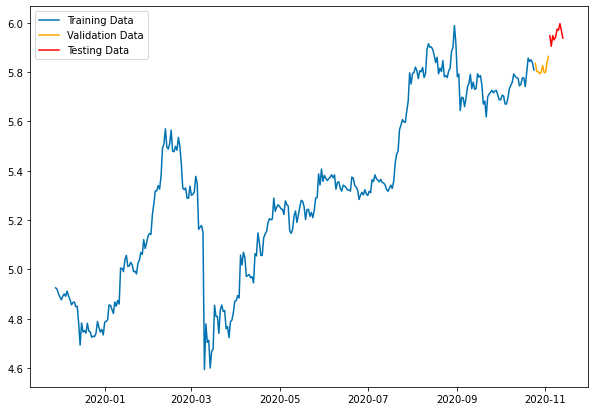

In [18]:
plt.figure(figsize=(10,7))
plt.plot(data_train.log_future, label='Training Data')
plt.plot(data_val.log_future, 'orange', label='Validation Data')
plt.plot(data_test.log_future, 'red', label='Testing Data')
plt.legend()

In [19]:
data_train.corr()

,price,market_cap,total_volume,log_price,future,log_future,diff1,diff2,diff3,diff5,diff7,diff10,move
price,1.000000,0.999795,0.099849,0.986578,0.972856,0.958599,0.070888,0.098545,0.118543,0.149235,0.179973,0.220175,0.074570
market_cap,0.999795,1.000000,0.089974,0.985537,0.973239,0.958279,0.068589,0.095620,0.114943,0.144876,0.174825,0.214362,0.072455
total_volume,0.099849,0.089974,1.000000,0.129705,0.092905,0.123685,0.060358,0.060496,0.097245,0.160730,0.164762,0.180656,0.100136
log_price,0.986578,0.985537,0.129705,1.000000,0.962797,0.971557,0.086752,0.115106,0.137687,0.176543,0.215751,0.263028,0.072397
future,0.972856,0.973239,0.092905,0.962797,1.000000,0.986583,0.057640,0.102170,0.122498,0.149848,0.174736,0.226179,0.063089
log_future,0.958599,0.958279,0.123685,0.971557,0.986583,1.000000,0.061908,0.121049,0.146998,0.183096,0.212512,0.267988,0.056693
diff1,0.070888,0.068589,0.060358,0.086752,0.057640,0.061908,1.000000,0.639783,0.590291,0.504619,0.391230,0.306626,0.595977
diff2,0.098545,0.095620,0.060496,0.115106,0.102170,0.121049,0.639783,1.000000,0.776346,0.642832,0.557164,0.431584,0.337018
diff3,0.118543,0.114943,0.097245,0.137687,0.122498,0.146998,0.590291,0.776346,1.000000,0.784953,0.694691,0.522127,0.317356
diff5,0.149235,0.144876,0.160730,0.176543,0.149848,0.183096,0.504619,0.642832,0.784953,1.000000,0.856187,0.703249,0.221511


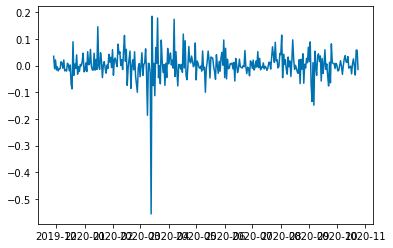

In [20]:
plt.plot(data_train.diff1)

It could be interesing to use the first order of differencing to remove the trend. There're also some outliers that should be removed.

## ARIMA

Just in case, we're trying to find any other best order using 'auto ARIMA' from *pmdarima* library.

In [21]:
X_train = data_train.log_price
X_val = data_val.log_price
y_val = data_val.log_future

In [22]:
import pmdarima as pm

arima = pm.auto_arima(X_train,
                      test='adf',
                      #d=1,
                      #m = 1, # week seasonality
                      seasonal=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1002.624, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-992.687, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1001.729, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1000.018, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-993.819, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1004.662, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1000.534, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1006.618, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1004.656, Time=0.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1002.085, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1007.530, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1000.769, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1002.469, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1005.549, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[

In [23]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  332
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 506.765
Date:                Mon, 16 Nov 2020   AIC                          -1007.530
Time:                        18:52:38   BIC                           -996.124
Sample:                             0   HQIC                         -1002.981
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8018      0.095     -8.398      0.000      -0.989      -0.615
ma.L1          0.6623      0.117      5.683      0.000       0.434       0.891
sigma2         0.0027   5.12e-05     53.443      0.000       0.003       0.003
===================================================================================
Ljung-Box (Q):                       41.87   Jarque-Bera (JB):             21628.22
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -3.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
start = len(X_train)
end = start + len(X_val)

# Rolling step with re-estimation
pred = pd.Series()
for i in range(start, end):
    yhat = arima.predict(n_periods=3)[-1]
    pred[data.index[i]] = yhat

    # updating the model
    arima = arima.update(data.log_price[i])

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


ARIMA Validation MAPE: 2.395


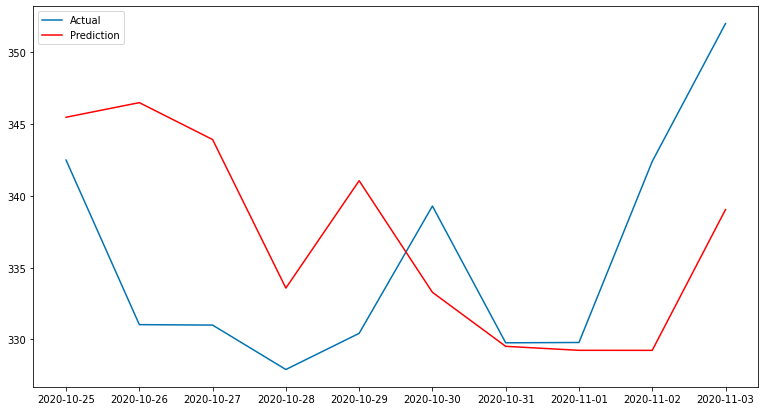

In [26]:
y_val = np.exp(y_val)
pred = np.exp(pred)
pred1 = pred.copy()

error = mean_absolute_percentage_error(y_val, pred)
print("{} Validation MAPE: {:.3f}".format('ARIMA', error))

# plot
plt.figure(figsize=(13,7))
plt.plot(y_val, label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend()
plt.show()

## Random Forest

In [27]:
X_train = data_train[['log_price', 'diff1','diff2','diff3','diff5','diff7','diff10','move']]
y_train = data_train.log_future

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, criterion='mae')
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Text(0.5, 0, 'Relative Importance')

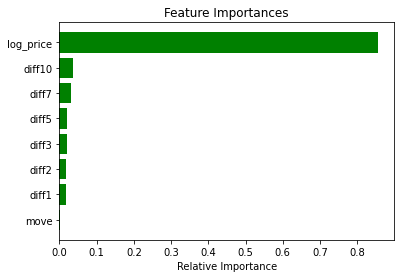

In [29]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Relative Importance')


In [30]:
# Define RF features to be used
RF_FEATURES = X_train.columns[indices[-5:]]

# Refit the model
rf.fit(X_train[RF_FEATURES], y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [31]:
X_val = data_val[RF_FEATURES]
y_val = data_val.log_future
pred = rf.predict(X_val)

Random Forest Validation MAPE: 1.983


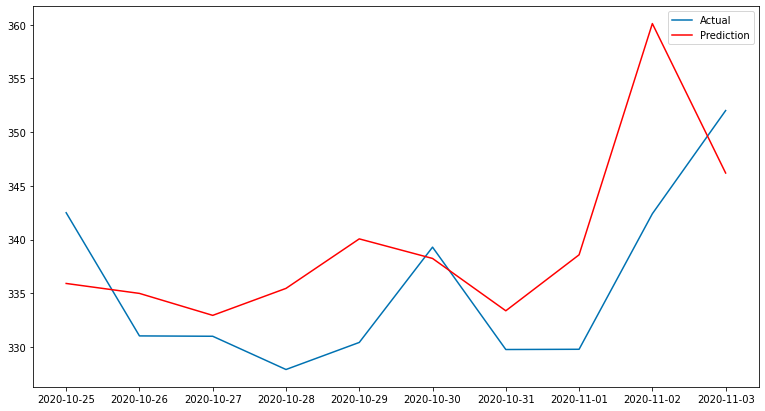

In [32]:
y_val = np.exp(y_val)
pred = np.exp(pred)
pred2 = pred.copy()

error = mean_absolute_percentage_error(y_val, pred)
print("Random Forest Validation MAPE: {:.3f}".format(error))

# plot
plt.figure(figsize=(13,7))
plt.plot(y_val, label='Actual')
plt.plot(data_val.index, pred, color='red', label='Prediction')
plt.legend()
plt.show()

## LSTM

In [33]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.3.0


The same dataset with differences is going to be used as before (Random Forest model) but now it's going to split the training data into a **validation set** as well.

In [34]:
FEATURES_LEN = len(RF_FEATURES)

In [35]:
from sklearn.preprocessing import StandardScaler

X_train = data_train[RF_FEATURES]
y_train = data_train.log_future

X_val = data_val[RF_FEATURES]
y_val = data_val.log_future

# Scale the features to keep all of them in the same range
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_val[X_val.columns] = scaler.transform(X_val[X_val.columns])

# Adapt to LSTM sequence shape
X_train_reshaped = X_train.values.reshape( (X_train.shape[0], 1 , FEATURES_LEN) )
X_val_reshaped = X_val.values.reshape( (X_val.shape[0], 1 , FEATURES_LEN) )

In [36]:
X_train.describe()

,diff3,diff5,diff7,diff10,log_price
count,3.320000e+02,3.320000e+02,3.320000e+02,3.320000e+02,3.320000e+02
mean,-4.012854e-17,-2.792278e-17,-2.541474e-17,3.344045e-18,-1.173760e-15
std,1.001509e+00,1.001509e+00,1.001509e+00,1.001509e+00,1.001509e+00
min,-6.899987e+00,-6.951021e+00,-5.533483e+00,-5.059513e+00,-1.981179e+00
25%,-4.288461e-01,-3.951859e-01,-4.206445e-01,-4.325008e-01,-8.323672e-01
50%,-1.971536e-02,-2.016196e-02,-3.207844e-02,4.153153e-02,4.670818e-02
75%,5.158769e-01,5.608256e-01,5.539435e-01,5.655756e-01,9.892757e-01
max,2.897744e+00,2.038985e+00,1.955659e+00,2.551187e+00,1.950058e+00


In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

lstm = Sequential()
lstm.add(LSTM(64, activation="tanh", input_shape=(1, FEATURES_LEN) ))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))
lstm.compile(loss='mean_absolute_percentage_error', optimizer='adam')

es_callback = EarlyStopping(monitor="loss", min_delta=0, patience=5, restore_best_weights=True)
history = lstm.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), shuffle=False, epochs=100, batch_size=32, verbose=1, callbacks=[es_callback])

Epoch 1/100
11/11 [==============================] - 0s 45ms/step - loss: 99.7467 - val_loss: 99.9766
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 98.6817 - val_loss: 99.2846
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 97.7057 - val_loss: 98.5148
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 96.6617 - val_loss: 97.7003
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 95.5908 - val_loss: 96.8245
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 94.3945 - val_loss: 95.8683
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 93.0508 - val_loss: 94.8130
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 91.5125 - val_loss: 93.6468
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 89.8598 - val_loss: 92.3416
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 88.0009 - val_lo

In [38]:
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(8,4.5))
    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def visualize_plot(model, X, y, title):
    index = y.index
    pred = model.predict(X)
    y = np.exp(y)
    pred = np.exp(pred)
    plt.figure(figsize=(8,4.5))
    plt.plot(index, y, label='Actual')
    plt.plot(index, pred, "red", label='Prediction')
    plt.title(title)
    plt.xlabel("Dates")
    plt.ylabel("Price (€)")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.gcf().autofmt_xdate()

def print_mape(model, X, y, title):
    pred = model.predict(X)
    y = np.exp(y)
    pred = np.exp(pred)
    error = mean_absolute_percentage_error(y, pred)
    print("{} MAPE in LSTM: {:.2f}".format(title, error))

Validation MAPE in LSTM: 6.43


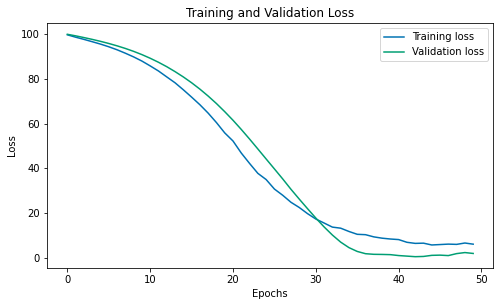

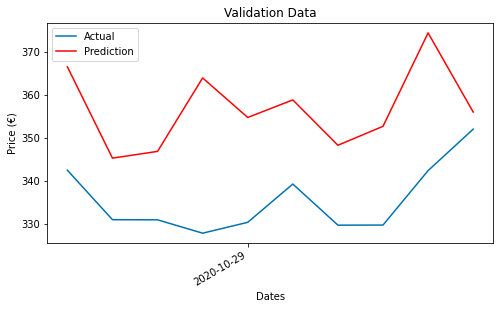

In [39]:
visualize_loss(history)
visualize_plot(lstm, X_val_reshaped, y_val, "Validation Data")
print_mape(lstm, X_val_reshaped, y_val, 'Validation')

# Testing the Models

Arima MAPE: 6.34
Random Forest MAPE: 15.15
LSTM MAPE: 8.03


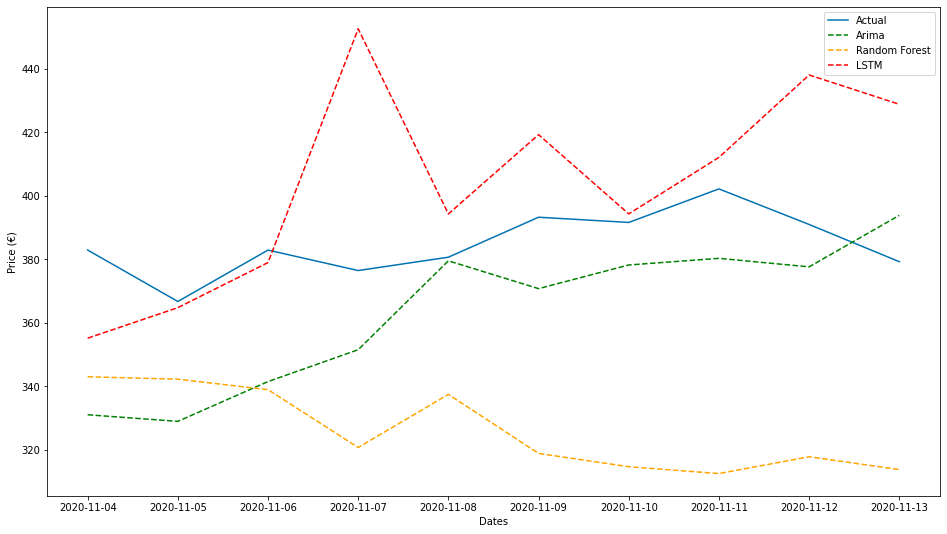

In [40]:
start = len(data_train) + len(data_val)
end = start + len(data_test)

## ARIMA
# Rolling step with re-estimation
pred1 = pd.Series()
for i in range(start, end):
    yhat = arima.predict(n_periods=3)[-1]
    pred1[data.index[i]] = yhat
    arima = arima.update(data.log_price[i])

## Random Forest
pred2 = rf.predict( data_test[RF_FEATURES] )

## LSTM
X_test = data_test[RF_FEATURES]
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.values.reshape((X_test.shape[0], 1, FEATURES_LEN))
pred3 = lstm.predict(X_test)

#
pred1 = np.exp(pred1)
pred2 = np.exp(pred2)
pred3 = np.exp(pred3)

#
mape1 = mean_absolute_percentage_error(data_test.future, pred1)
mape2 = mean_absolute_percentage_error(data_test.future, pred2)
mape3 = mean_absolute_percentage_error(data_test.future, pred3)

#
print("Arima MAPE: {:.2f}".format(mape1))
print("Random Forest MAPE: {:.2f}".format(mape2))
print("LSTM MAPE: {:.2f}".format(mape3))

##
plt.figure(figsize=(16,9))
plt.plot(data_test.index, data_test.future, label='Actual')
plt.plot(data_test.index, pred1, "green", linestyle='dashed', label='Arima')
plt.plot(data_test.index, pred2, "orange", linestyle='dashed', label='Random Forest')
plt.plot(data_test.index, pred3, "red", linestyle='dashed', label='LSTM')
plt.xlabel("Dates")
plt.ylabel("Price (€)")
plt.legend()
plt.show()

---
# References

Data Trend and Seasonality
* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* https://en.wikipedia.org/wiki/Decomposition_of_time_series

AR and MA orders using ACF+PACF
* https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

Augmented Dickey-Fuller unit root test
* https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html
* https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test
